# Aphid-Ladybeetle study

In [1]:
import copy
import numpy as np  # linear algebra
from numba import jit

import arviz as az
from arviz.utils import Numba
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd
import pymc3 as pm  # for uncertainty quantification and model calibration
import theano  # to control better pymc3 backend and write a wrapper
import theano.tensor as t  # for the wrapper to a custom model to pymc3
import time
from tqdm.autonotebook import tqdm
import warnings
import sys

np.seterr('warn')
warnings.filterwarnings("ignore")
az.style.use("default")#,"arviz-colors")
#az.style.use("arviz-darkgrid")

Numba.enable_numba()

seed=1234
np.random.seed(seed)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/tmp/ipykernel_69631/3528856776.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Obtaining Initial Conditions

We need to define Initial Conditions as functions in order to define them for each discretization point. Here we will fit ICs as polynomial functions.

Loading data:

### 2018_Lin_and_Pennings

In [2]:
data_dir = "../data/"
aphid_data = pd.read_csv(data_dir + 'aphid.CSV')
ladybeetle_data = pd.read_csv(data_dir + 'ladybeetle.CSV')

Retrieving IC data:

In [3]:
aphid_ic = aphid_data[aphid_data.Time == 1].Density.values[0]
ladybeetle_ic = ladybeetle_data[ladybeetle_data.Time == 1].Density.values[0]

aphid_density = aphid_data["Density"].values.flatten()
ladybeetle_density = ladybeetle_data["Density"].values.flatten()
time_list = aphid_data["Time"].values.flatten()

# Regularization

In [4]:
#%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, ExpSineSquared

In [5]:
def read_data_file(path, filename):
    raw_data = pd.read_csv(f"{path}/{filename}", usecols=["Time", "Density"])
    return raw_data

In [6]:
def plot_data(time_list, density, mean_density, min_density, max_density):
    fig, ax = plt.subplots(figsize=(7, 4))
    
    ax.plot(time_list, density, 'o', c='b')
    ax.plot(t_list, mean_density, c='#000080')
    
    plt.xlabel('Time (days)')
    
    ax.set_ylim([0, 3233])
    plt.rc('axes', labelsize=20, titlesize=40),plt.xticks(fontsize=18),plt.yticks(fontsize=18)
#    plt.xticks(color='w'),plt.yticks(color='w')

    fig.set_tight_layout(True)

    ax.fill_between(t_list,
                    min_density,
                    max_density,
                    alpha=0.2,
                    color='blue')

In [7]:
t_list = time_list
t_list = np.linspace(t_list[0], t_list[-1], 200)
#t_list = np.linspace(-10, 50, 200)

def regularize_data(time_list, density):
    kernel = RBF(length_scale_bounds=(10,100)) + WhiteKernel(noise_level_bounds=(1e-10, 5e-10))

    model = GaussianProcessRegressor(kernel=kernel, alpha=1.0e-10, n_restarts_optimizer=50, normalize_y=np.max(density))
    model.fit(time_list.reshape(-1, 1), density)
    target_pred = model.predict(t_list.reshape(-1, 1), return_std=True)
    
    print(str(model.kernel_.get_params()))
    print("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, model.kernel_,
             model.log_marginal_likelihood(model.kernel_.theta)))
    
    mean_density = target_pred[0]
    err = 1.96 * np.max(density) * target_pred[1]
    min_density = target_pred[0] - err
    max_density = target_pred[0] + err
    
    return (mean_density, min_density, max_density)

Text(0, 0.5, 'Aphid Abundance')

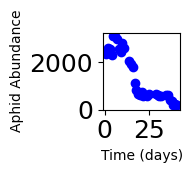

In [8]:
fig, ax = plt.subplots(figsize=(1, 1))

ax.set_ylim([0, 3233])

ax.plot(time_list, aphid_data.Density.values, 'o', c='b')
ax.set(xlabel='Time (days)')
plt.rc('axes', labelsize=20, titlesize=40),plt.xticks(fontsize=18),plt.yticks(fontsize=18)
plt.ylabel('Aphid Abundance')

{'k1': RBF(length_scale=10), 'k2': WhiteKernel(noise_level=5e-10), 'k1__length_scale': 10.000000000000002, 'k1__length_scale_bounds': (10, 100), 'k2__noise_level': 5.000000000000012e-10, 'k2__noise_level_bounds': (1e-10, 5e-10)}
Initial: RBF(length_scale=1) + WhiteKernel(noise_level=1)
Optimum: RBF(length_scale=10) + WhiteKernel(noise_level=5e-10)
Log-Marginal-Likelihood: -525176647.22261643


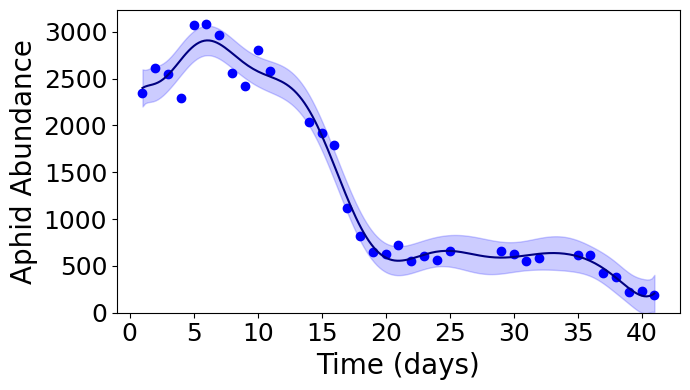

In [9]:
(mean_density, min_density, max_density) = regularize_data(time_list, aphid_density)
plot_data(time_list, aphid_density, mean_density, min_density, max_density)
plt.ylabel('Aphid Abundance')
plt.savefig("img/reg_aphid.png", dpi=300)

In [10]:
aphid_density = mean_density

In [11]:
t_list = time_list
t_list = np.linspace(t_list[0], t_list[-1], 200)

def regularize_data(time_list, density):
    kernel = ConstantKernel(constant_value_bounds = (1.0e-1, 1.0)) + WhiteKernel(noise_level_bounds = (1.0e-3, 1.0e-2))

    model = GaussianProcessRegressor(kernel=kernel, alpha=1.0e-10, n_restarts_optimizer=50, normalize_y=np.max(density))
    model.fit(time_list.reshape(-1, 1), density)
    target_pred = model.predict(t_list.reshape(-1, 1), return_std=True)
    
    print(str(model.kernel_.get_params()))
    print("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, model.kernel_,
             model.log_marginal_likelihood(model.kernel_.theta)))
    
    mean_density = target_pred[0]
    err = 1.96 * np.max(density) * target_pred[1]
    min_density = target_pred[0] - err
    max_density = target_pred[0] + err
    
    return (mean_density, min_density, max_density)

In [12]:
def plot_data(time_list, density, mean_density, min_density, max_density):
    fig, ax = plt.subplots(figsize=(7, 4))
    
    ax.plot(time_list, density, 'o', c='r')
    ax.plot(t_list, mean_density, c='#800000')
    
    plt.xlabel('Time (days)')
    
    ax.set_ylim([-0.2, 10])
    plt.rc('axes', labelsize=20, titlesize=40),plt.xticks(fontsize=18),plt.yticks(fontsize=18)
#    plt.xticks(color='w'),plt.yticks(color='w')

    fig.set_tight_layout(True)

    ax.fill_between(t_list,
                    min_density,
                    max_density,
                    alpha=0.2,
                    color='#FF6347')

{'k1': 0.316**2, 'k2': WhiteKernel(noise_level=0.01), 'k1__constant_value': 0.10000000000000006, 'k1__constant_value_bounds': (0.1, 1.0), 'k2__noise_level': 0.010000000000000005, 'k2__noise_level_bounds': (0.001, 0.01)}
Initial: 1**2 + WhiteKernel(noise_level=1)
Optimum: 0.316**2 + WhiteKernel(noise_level=0.01)
Log-Marginal-Likelihood: -1655.8719413708159


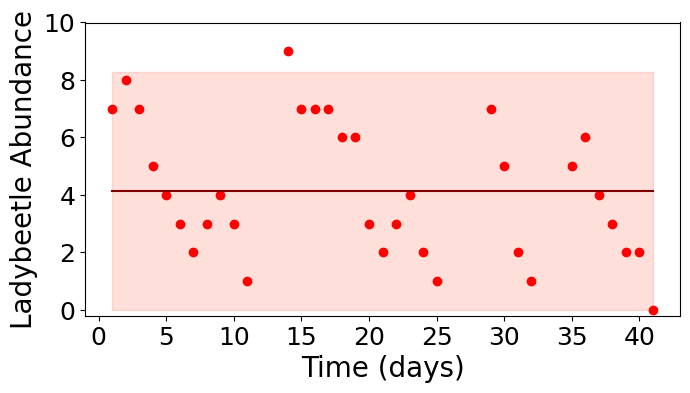

In [13]:
(mean_density, min_density, max_density) = regularize_data(time_list, ladybeetle_density)
plot_data(time_list, ladybeetle_density, mean_density, min_density, max_density)
plt.ylabel('Ladybeetle Abundance')
plt.savefig("img/reg_ladybeetle.png", dpi=300)

In [14]:
ladybeetle_density = mean_density

In [15]:
aphid_ic = aphid_density[0]
ladybeetle_ic = ladybeetle_density[0]

In [16]:
y0 = aphid_ic, ladybeetle_ic

y0

(2400.511917153086, 4.147058823529371)

In [17]:
time_list = t_list

# Model 4

In [18]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

y0 = 2719.3794153268414, 4.147056509871602

@jit(nopython=True)
def M04_model(
    t,
    X,
    r2 = 7.712e-06,
    r3 = 5.226e-08,
    a12 = 2.902e-04,
    a21 = 3.212e-05,
):
    """
    Prey-Predator M04 Model python implementation.
    """
    u, v = X
    u_prime = - r2*u**2 + r3*u**3 - a21*u**2*v - a12*u*v**2
    v_prime = 0.0
    return u_prime, v_prime

def M04_ode_solver(
    y0,
    t_span,
    t_eval,
    r2 = 7.712e-06,
    r3 = 5.226e-08,
    a12 = 2.902e-04,
    a21 = 3.212e-05,
):
    solution_ODE = solve_ivp(
        fun=M04_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r2, r3, a12, a21),
        method="Radau",
    )
    return solution_ODE

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, len(time_list))

u_data = aphid_density
v_data = ladybeetle_density

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [19]:
def M04_least_squares_error_ode(
    par, time_list_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_list_span = (time_list_exp.min(), time_list_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_list_span, time_list_exp, *args)
        simulated_time_list = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [20]:
from scipy import optimize

seed=seed

r2 = 7.712e-06
r3 = 5.226e-08
a12 = 2.902e-04
a21 = 3.212e-05
denom_min = 1
denom_max = 1
bounds_M04 = [
    ( ( r2 * denom_min ), ( r2 * denom_max ) ),
    ( ( r3 * denom_min ), ( r3 * denom_max ) ),
    ( ( a12 * denom_min ), ( a12 * denom_max ) ),
    ( ( a21 * denom_min ), ( a21 * denom_max ) ),
]

result_M04 = optimize.differential_evolution(
    M04_least_squares_error_ode,
    bounds=bounds_M04,
    args=(
        time_list,
        [aphid_density, ladybeetle_density],
        M04_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=10000,
    polish=True,
    disp=True,
    seed=seed,
    callback=callback_de,
    workers=-1,
)

print(result_M04)

differential_evolution step 1: f(x)= 4.86786e+06
parameters = [7.712e-06 5.226e-08 2.902e-04 3.212e-05]

     fun: 4867861.89516093
 message: 'Optimization terminated successfully.'
    nfev: 245
     nit: 1
 success: True
       x: array([7.712e-06, 5.226e-08, 2.902e-04, 3.212e-05])


* Retrieving the calibrated parameter values:

In [21]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r2_deterministic,
    r3_deterministic,
    a12_deterministic,
    a21_deterministic,
) = result_M04.x

solution_ODE_M04 = M04_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_list_range, 
    *result_M04.x
)
t_computed_M04, y_computed_M04 = solution_ODE_M04.t, solution_ODE_M04.y
u_M04, v_M04 = y_computed_M04

parameters_dict = {
    "Model": "M04",
    u"$r2$": r2_deterministic,
    u"$r3$": r3_deterministic,
    u"$a12$": a12_deterministic,
    u"$a21$": a21_deterministic,
}

print("r2=" + str(r2_deterministic) + "\n" + "r3=" + str(r3_deterministic)  + "\n" + "a12=" + str(a12_deterministic) + "\n" + "a21=" + str(a21_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])

r2=7.712e-06
r3=5.226e-08
a12=0.0002902
a21=3.212e-05


#### Simulation

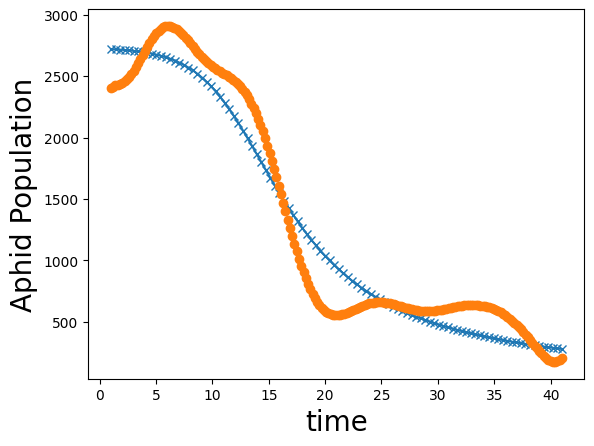

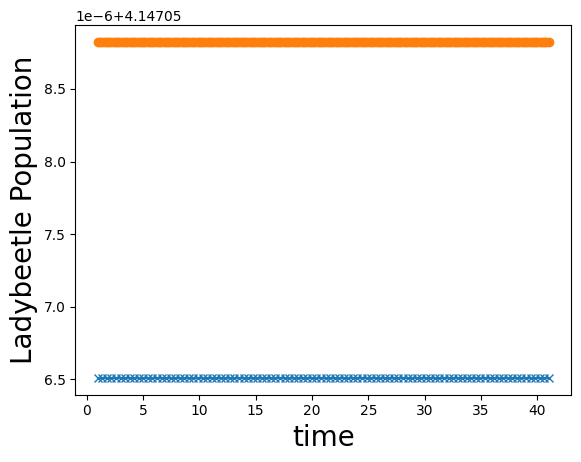

In [22]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_M04, u_M04, '-x')
plt.plot(time_list, aphid_density, 'o', label='Observed')

plt.xlabel('time')
plt.ylabel('Aphid Population')
plt.show()

plt.plot(t_computed_M04, v_M04, '-x')
plt.plot(time_list, ladybeetle_density, 'o', label='Observed')
plt.xlabel('time')
plt.ylabel('Ladybeetle Population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [23]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r2,
    r3,
    a12,
    a21,
]
factors_names = [
    r"$r2$",
    r"$r3$",
    r"$a12$",
    r"$a21$",
]
params_perturbations = 0.001
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=True, seed=seed)

In [24]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = M04_least_squares_error_ode(
        parameters_realization,
        time_list,
        [u_data, v_data],
        M04_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 220.59it/s]


In [25]:
from SALib.analyze.morris import analyze as ee_analyze

data_time_list = time_list
num_of_experimental_points = data_time_list.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

,$\mu^*$
$r3$,0.554977
$a21$,0.41035
$r2$,0.028287
$a12$,0.006385


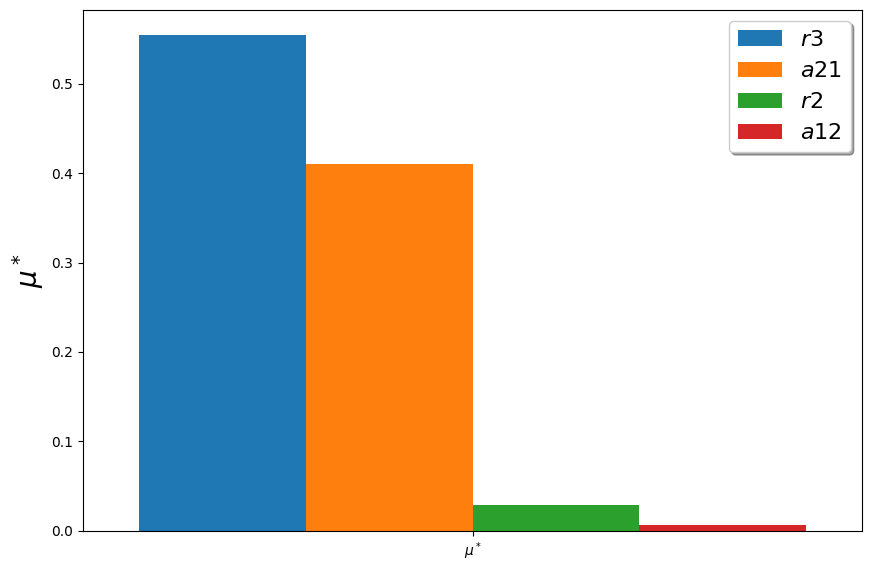

In [26]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

### Prey (pest) population

In [27]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r2,
    r3,
    a12,
    a21,
]
factors_names = [
    r"$r2$",
    r"$r3$",
    r"$a12$",
    r"$a21$",
]
params_perturbations = 0.001
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=True, seed=seed)

In [28]:
from tqdm import tqdm

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_M04 = M04_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_M04.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 142.73it/s]


In [29]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
    Si = ee_analyze(
        problem_info, 
        parameter_values, 
        qoi_sensitivity_outputs[:, time_list_point], 
        num_levels=grid_level, 
        seed=seed
    )
    # Some parameters combinations may result in simulation failure.
    # This "if" skip such cases, since they do not have associated sensitivity indicies
    if np.isnan(Si["mu"][-1]):
        continue
        
    Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
    sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
    for idx, param_name in enumerate(problem_info['names']):
        df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
        df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]

df_Si.dropna(inplace=True)  # remove values that calculation was not possible
df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 312.46it/s]


,time_list,$r2$,$r3$,$a12$,$a21$
0,1.404040,0.027111,0.498574,0.006449,0.467865
1,1.808081,0.027088,0.498622,0.006452,0.467838
2,2.212121,0.027089,0.49856,0.006455,0.467896
3,2.616162,0.027102,0.498425,0.006458,0.468015
4,3.020202,0.027121,0.49824,0.006463,0.468176
...,...,...,...,...,...
94,39.383838,0.030238,0.468972,0.007712,0.493078
95,39.787879,0.030184,0.468896,0.007816,0.493104
96,40.191919,0.030218,0.468744,0.007905,0.493133
97,40.595960,0.030275,0.46858,0.007967,0.493177


In [30]:
df_sigmai

,time_list,$r2$,$r3$,$a12$,$a21$
0,1.404040,0.034756,0.497443,0.006151,0.46165
1,1.808081,0.020084,0.586414,0.001449,0.392053
2,2.212121,0.070012,0.482104,0.012862,0.435023
3,2.616162,0.015747,0.561396,0.002888,0.419969
4,3.020202,0.022516,0.529794,0.00462,0.443069
...,...,...,...,...,...
94,39.383838,0.03655,0.485881,0.008365,0.469204
95,39.787879,0.036942,0.485356,0.007924,0.469777
96,40.191919,0.03679,0.485376,0.007554,0.47028
97,40.595960,0.036611,0.485461,0.007297,0.470631


In [31]:
az.style.use(["arviz-white", "arviz-plasmish"])

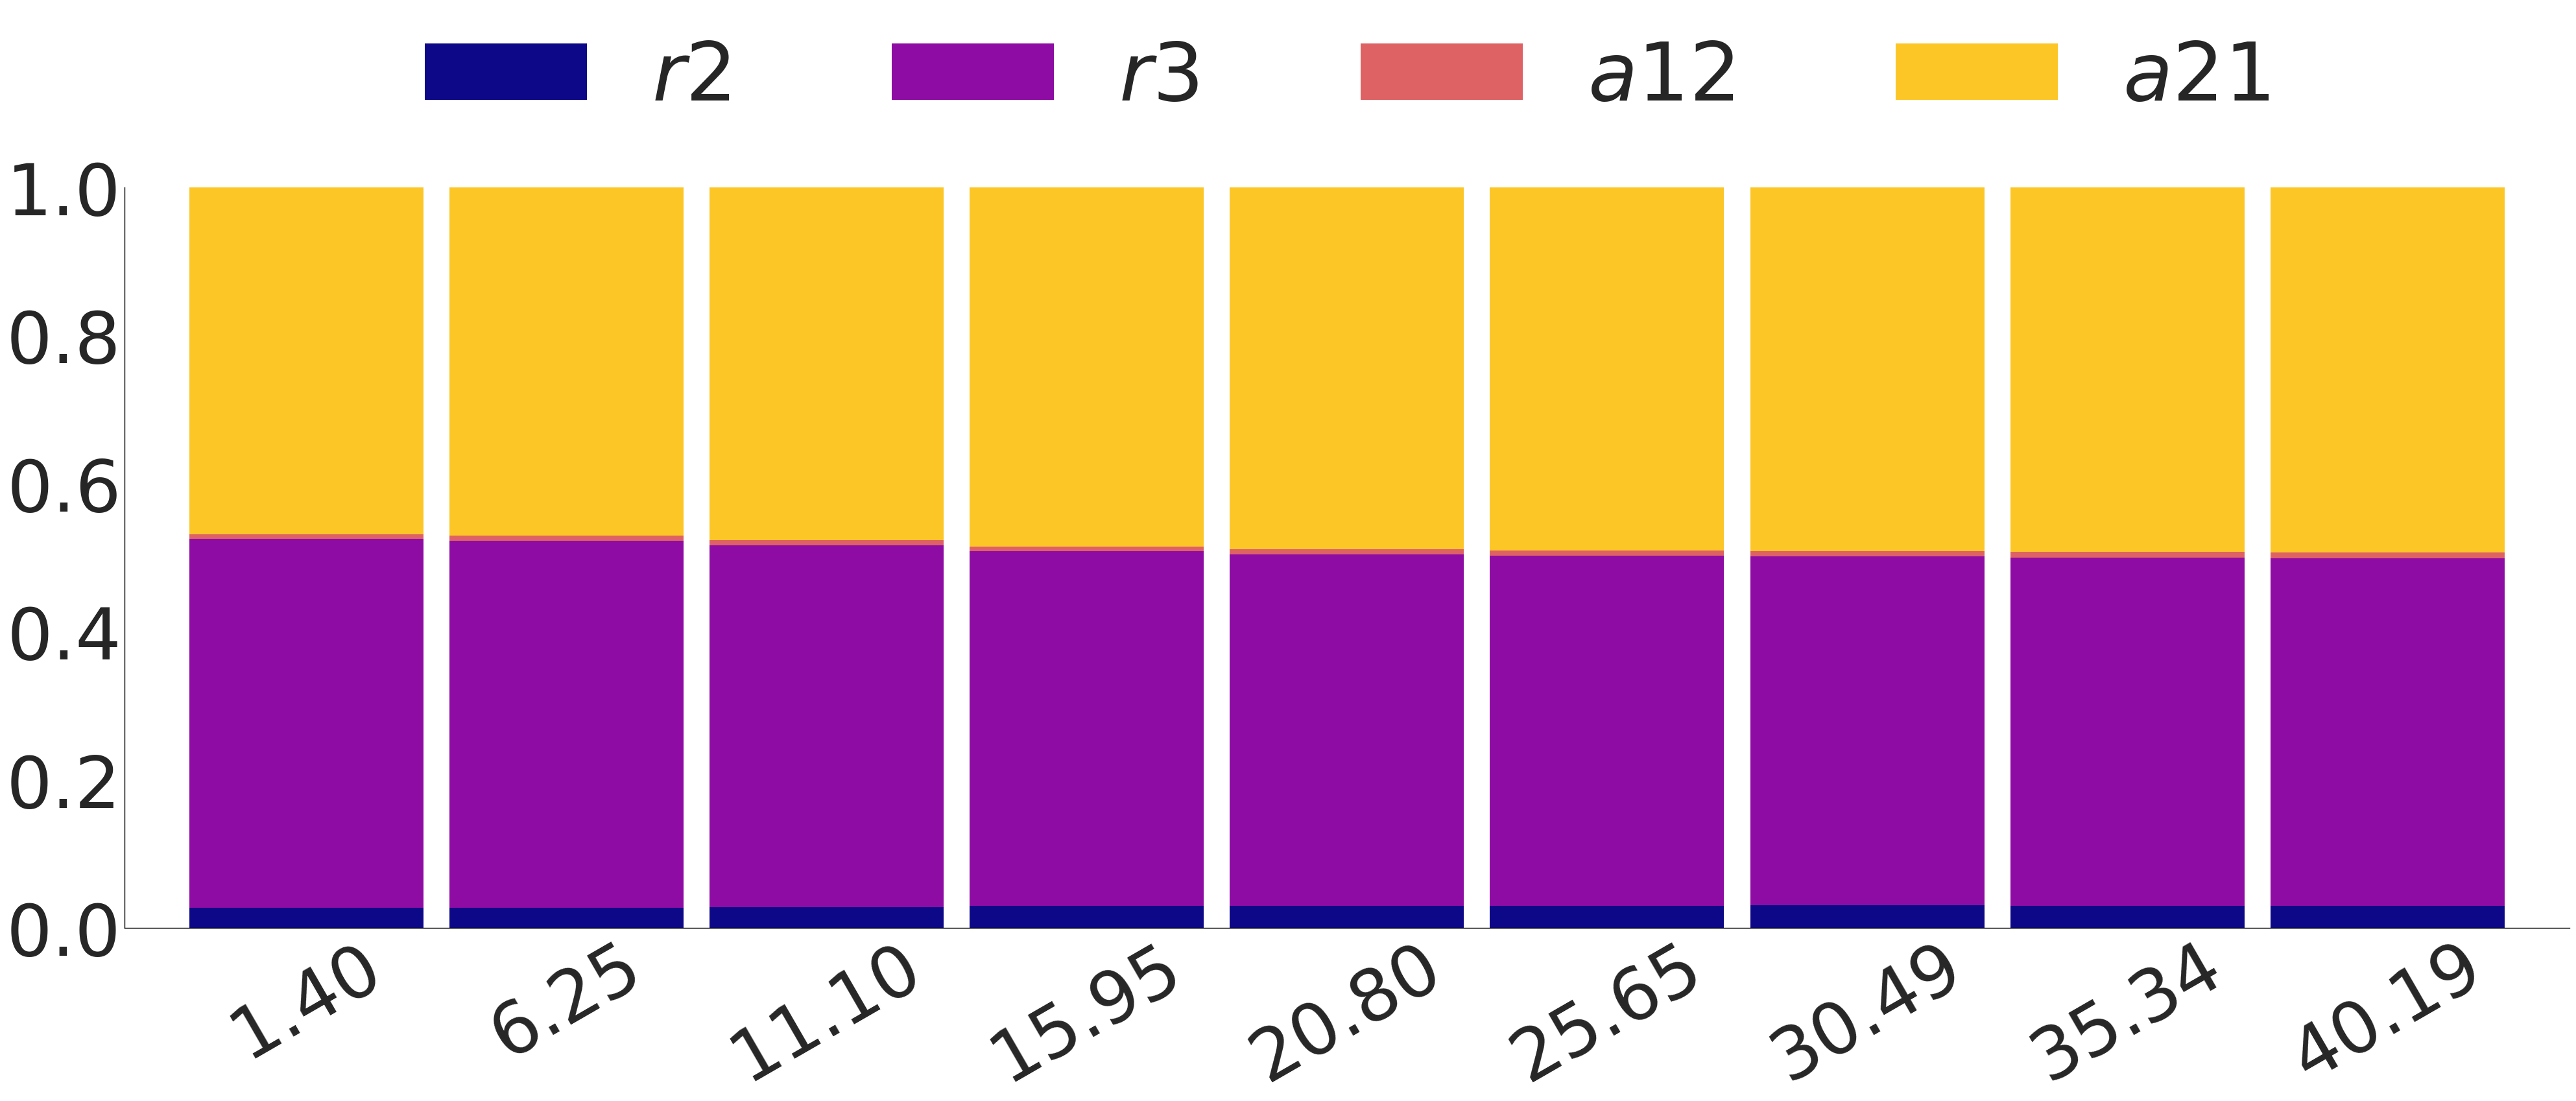

In [32]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 12
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='time_list', rot=30, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
#plt.xlabel("Time (days)", fontsize = 80), plt.ylabel(r"Normalized $\mu^*$", fontsize = 80), plt.xticks(fontsize=80), plt.yticks(fontsize=80)
plt.xlabel("", fontsize = 80), plt.ylabel("", fontsize = 80), plt.xticks(fontsize=80), plt.yticks(fontsize=80)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=90)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_M04.png", format='png', bbox_inches = 'tight', dpi=50)
plt.show()

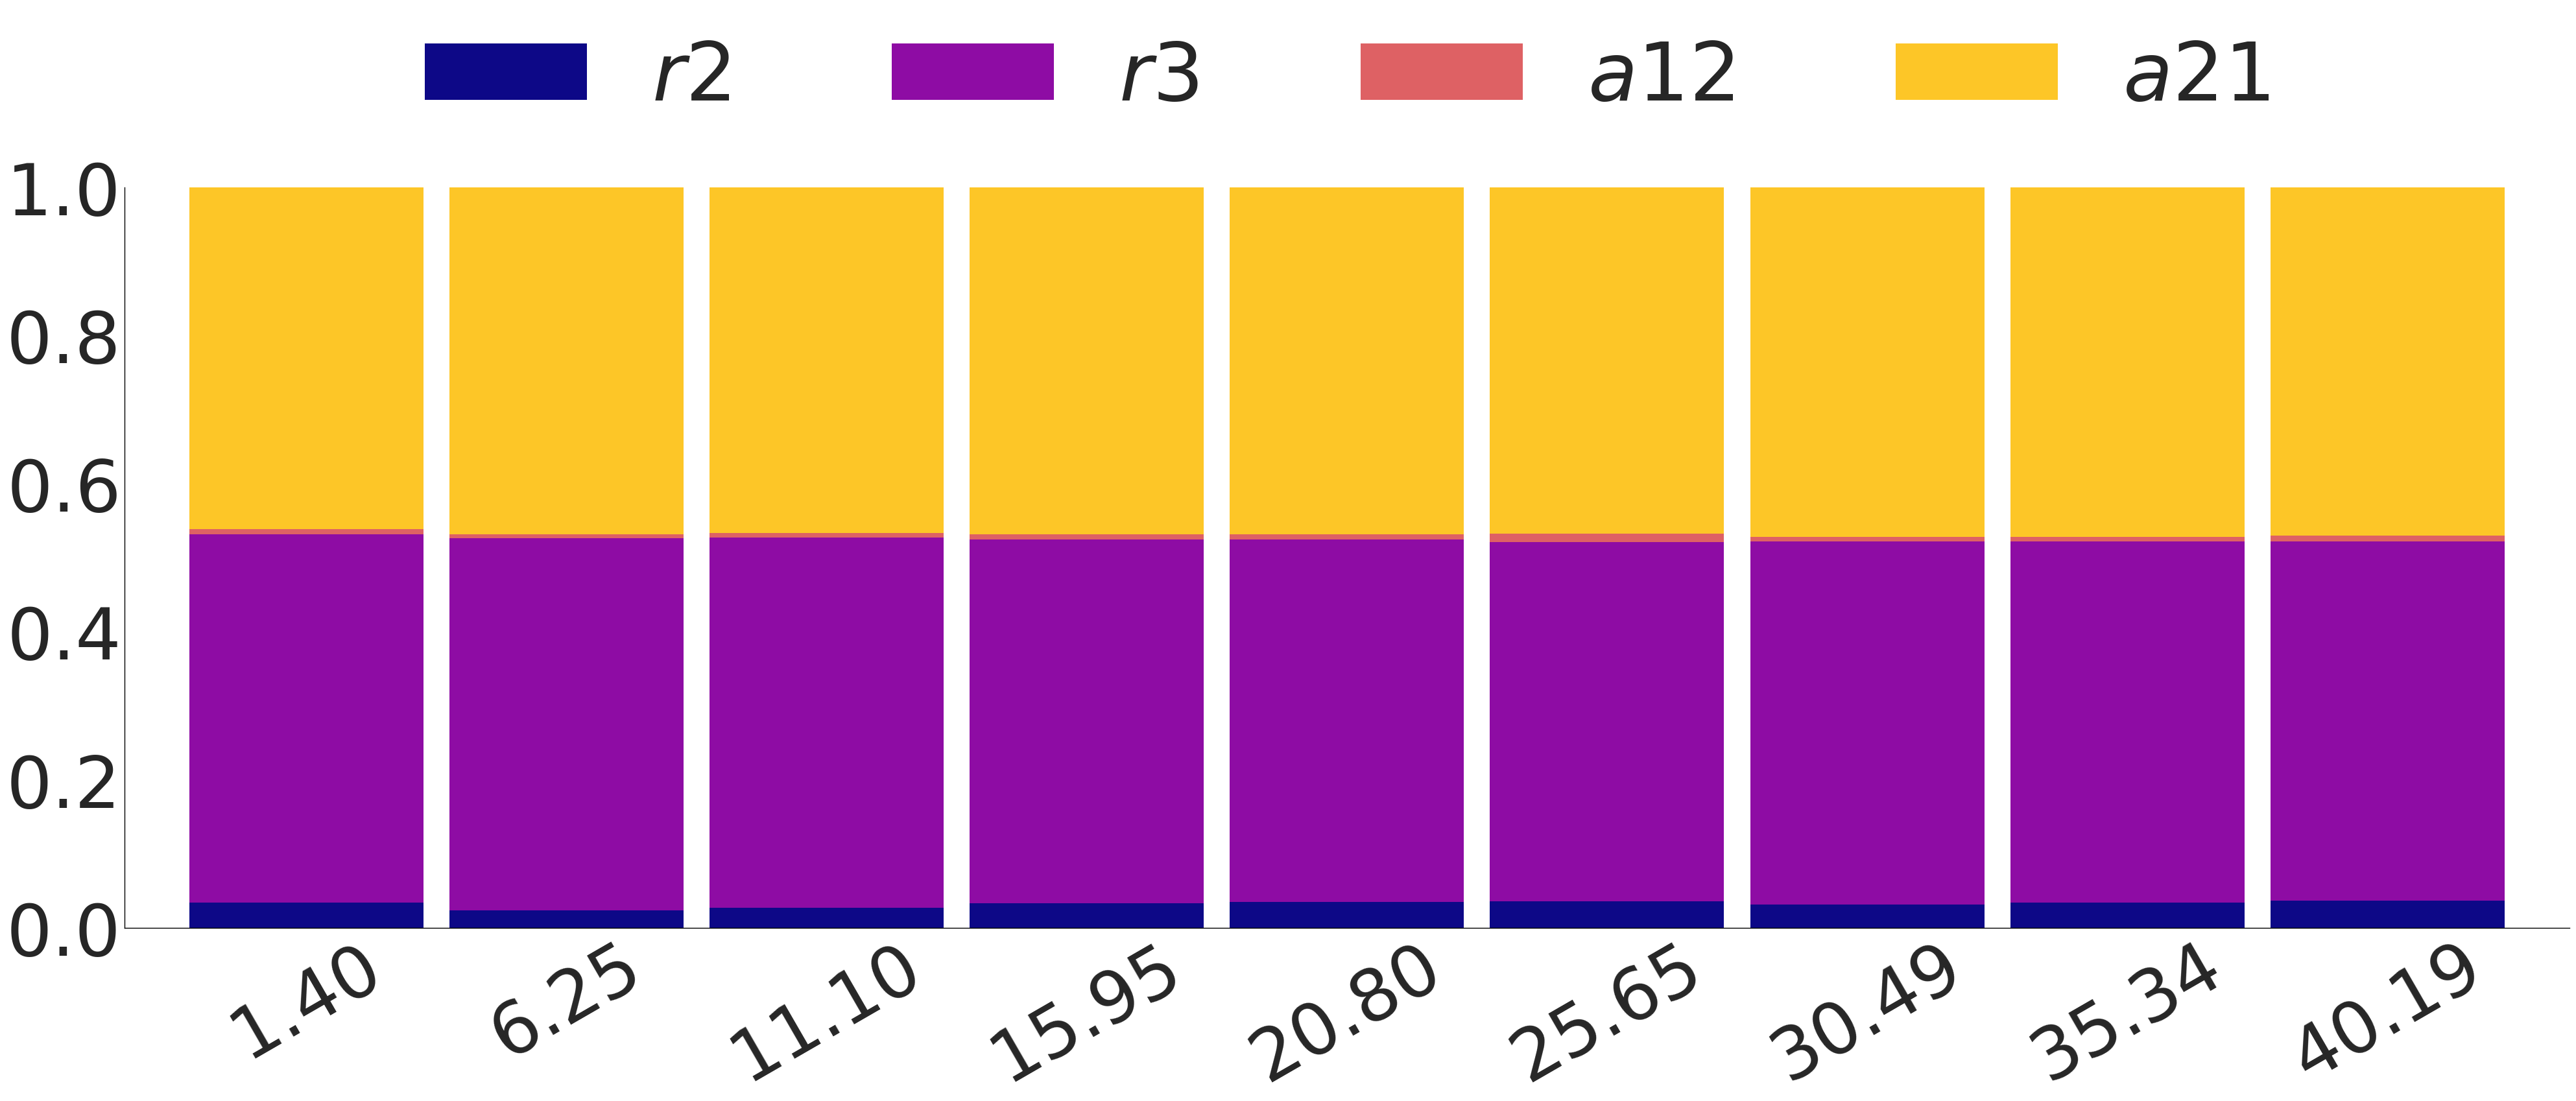

In [33]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 12
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=30, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
#plt.xlabel("Time (days)", fontsize = 80), plt.ylabel(r"Normalized $\sigma$", fontsize = 80), plt.xticks(fontsize=80), plt.yticks(fontsize=80)
plt.xlabel("", fontsize = 80), plt.ylabel("", fontsize = 80), plt.xticks(fontsize=80), plt.yticks(fontsize=80)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=90)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_M04.png", format='png', bbox_inches = 'tight', dpi=50)
plt.show()

In [34]:
az.style.use("default")

## Bayesian calibration

In [35]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r2
        t.dscalar,  # r3
        t.dscalar,  # a12
        t.dscalar,  # a21
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def M04_ode_wrapper(time_list_exp, r2,r3,a12,a21, u0, v0):
    time_list_span = (time_list_exp.min(), time_list_exp.max())

    args = [r2,r3,a12,a21]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        M04_model, 
        time_list_span, 
        initial_conditions, 
        t_eval=time_list_exp, 
        method='Radau',
        args=args
    )
    simulated_time_list = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [36]:
observed_aphids = aphid_density.astype(np.float64)
observed_ladybeetles = ladybeetle_density.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = time_list.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
start_time = time.time()
denom_min = 0.999
denom_max = 1.001

with pm.Model() as fine_model_M04:
    # Prior distributions for the model's parameters    
    r2_ = pm.Data("r2", r2)
    r3_ = pm.Uniform(
        "r3",
        lower=( r3 * denom_min ),
        upper=( r3 * denom_max ),
    )
    a12_ = pm.Data("a12", a12)
    a21_ = pm.Uniform(
        "a21",
        lower=( a21 * denom_min ),
        upper=( a21 * denom_max ),
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=300, shape=2)  # note 'shape' here

    # Wrapper for time_list. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "M04_model",
        M04_ode_wrapper(
            time_calibration,
            r2_,
            r3_,
            a12_,
            a21_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
    r2_ = pm.Data("r2", r2)
    r3_ = pm.Uniform(
        "r3",
        lower=( r3 * denom_min ),
        upper=( r3 * denom_max ),
    )
    a12_ = pm.Data("a12", a12)
    a21_ = pm.Uniform(
        "a21",
        lower=( a21 * denom_min ),
        upper=( a21 * denom_max ),
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=300, shape=2)  # note 'shape' here

    # Wrapper for time_list. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "M04_model",
        M04_ode_wrapper(
            time_calibration,
            r2_,
            r3_,
            a12_,
            a21_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )


with fine_model_M04:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
    trace_calibration_M04 = pm.sample(draws=6000, chains=6, cores=6, step=step, random_seed=seed, tune=2000)#, start={'r3': (5.2264665899163776e-08), 'a21': (3.212465447661946e-05), 'std_deviation': np.array([220.,2e-06])})

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Multiprocess sampling (6 chains in 6 jobs)
MLDA: [std_deviation, a21, r3]


Sampling 6 chains for 2_000 tune and 6_000 draw iterations (12_000 + 36_000 draws total) took 1064 seconds.
The number of effective samples is smaller than 10% for some parameters.


-- Monte Carlo simulations done in 20.079 minutes


plt.hist(trace_calibration_M04['r3'], bins=35)
plt.show()
plt.hist(trace_calibration_M04['a21'], bins=35)
plt.show()

100%|████████████████████████████████████████████| 3/3 [07:29<00:00, 149.97s/it]


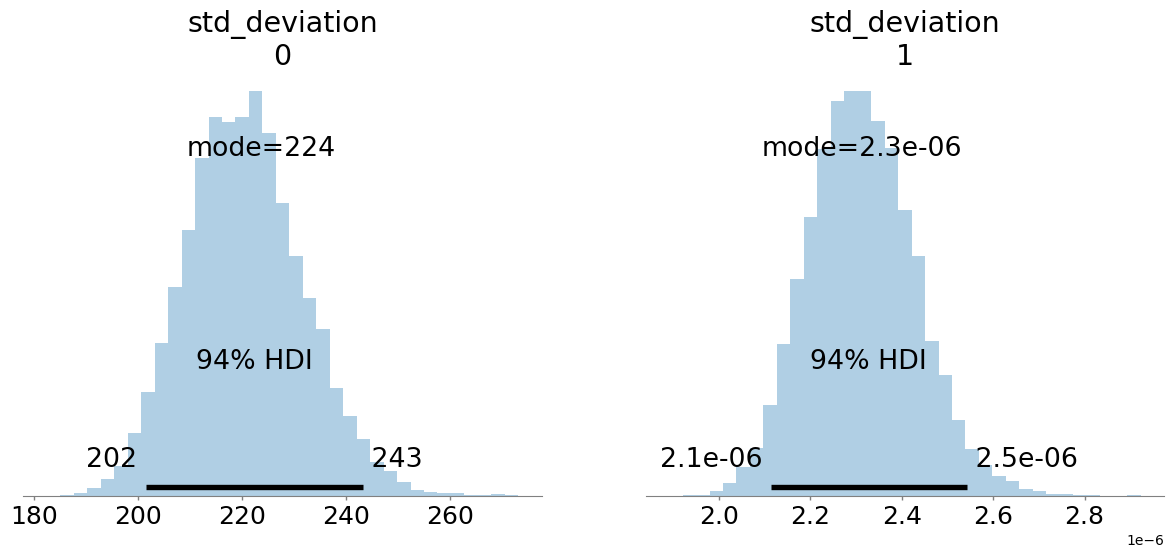

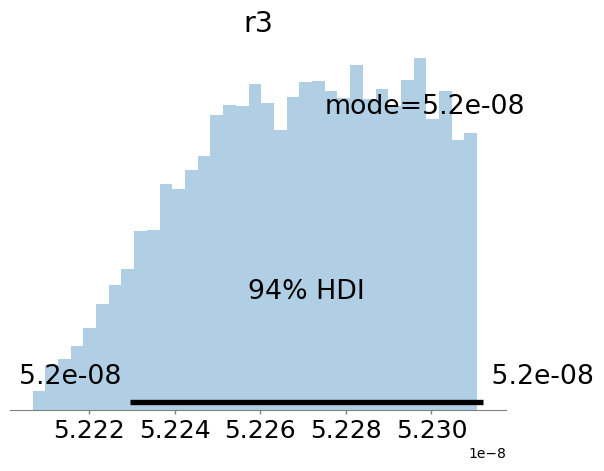

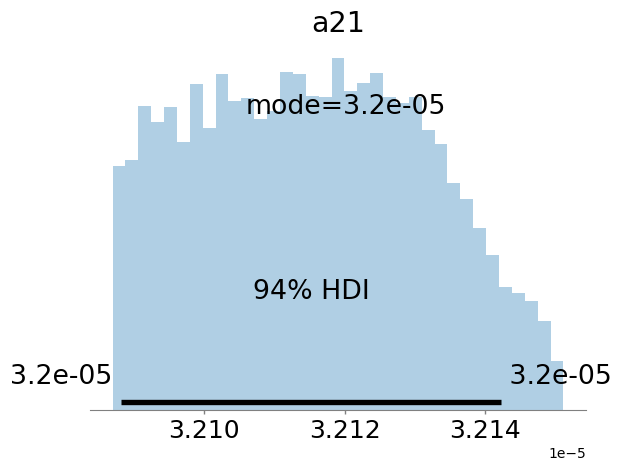

In [37]:
calibration_variable_names = [
    "std_deviation",
    "r3",
    "a21",
]

plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_M04[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist",
        bins=35,
        round_to=None,
        textsize=18,
        point_estimate="mode"
    )
    plt.savefig(f"img/posterior_cal_M04_{variable}.png", bbox_inches='tight', pad_inches=0)

100%|████████████████████████████████████████████| 3/3 [06:54<00:00, 138.13s/it]


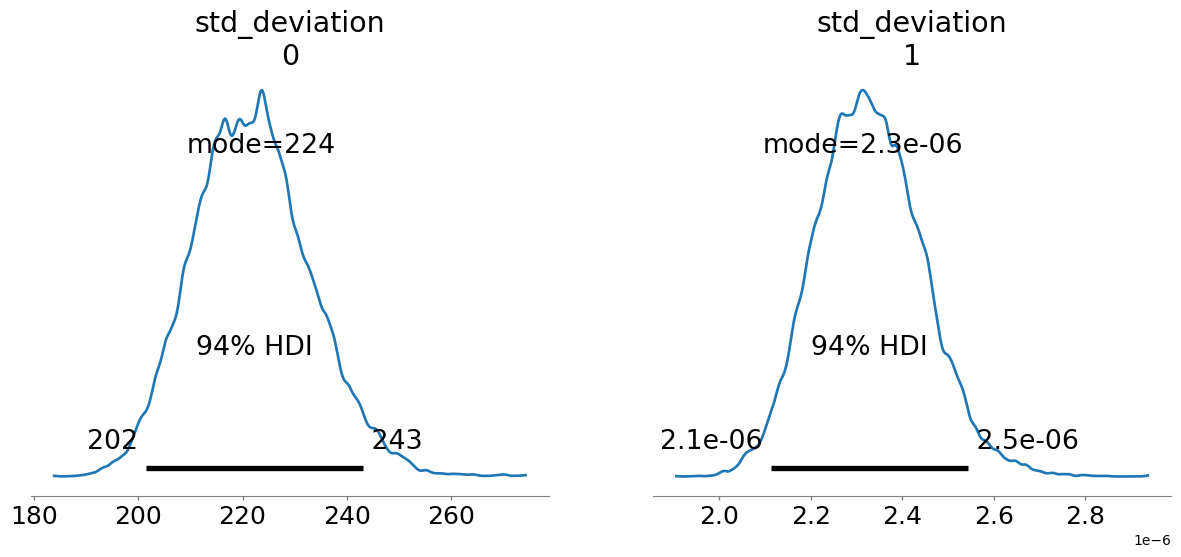

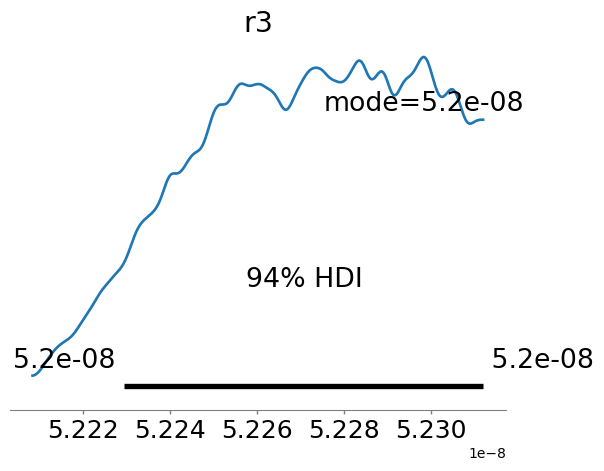

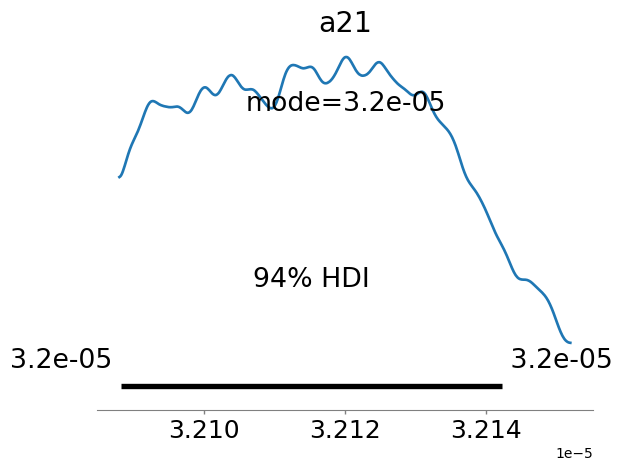

In [38]:
calibration_variable_names = [
    "std_deviation",
    "r3",
    "a21",
]

plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_M04[::plot_step], 
        var_names=(f"{variable}"), 
        kind="kde",
        bins=35,
        round_to=None,
        textsize=18,
        point_estimate="mode"
    )
#    plt.savefig(f"img/posterior_cal_M04_KDE_{variable}.png", bbox_inches='tight', pad_inches=0)

Got error No model on context stack. trying to find log_likelihood in translation.


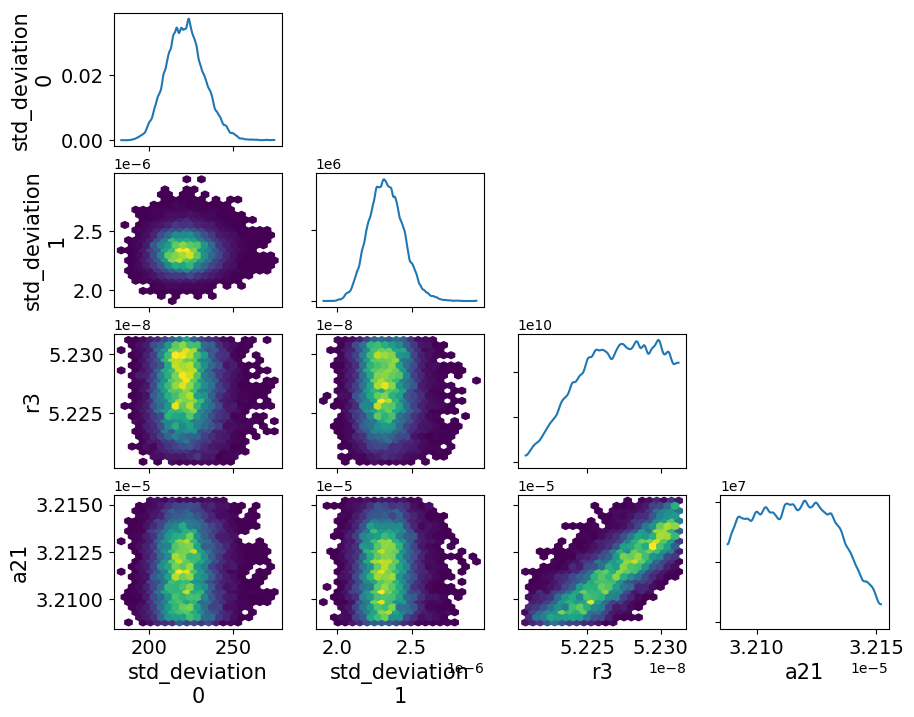

In [39]:
az.plot_pair(
    trace_calibration_M04,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_M04.png")

In [40]:
df_stats_summary = az.summary(
    data=trace_calibration_M04,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # rounding level display
)

df_stats_summary

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%
std_deviation[0],2.218955e+02,1.120317e+01,2.015050e+02,2.431292e+02
std_deviation[1],2.328278e-06,1.165800e-07,2.113094e-06,2.542761e-06
r3,5.227060e-08,2.501800e-11,5.222943e-08,5.231217e-08
a21,3.211625e-05,1.618986e-08,3.208816e-05,3.214231e-05


In [41]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [42]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_M04, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_M04.csv")  # save in csv format

df_stats_summary

Calculating MPV from KDE for a21: 100%|███████████| 3/3 [00:49<00:00, 16.40s/it]


,mean,sd,hdi_3%,hdi_97%,mpv
std_deviation[0],2.218955e+02,1.120317e+01,2.015050e+02,2.431292e+02,2.234776e+02
std_deviation[1],2.328278e-06,1.165800e-07,2.113094e-06,2.542761e-06,2.314971e-06
r3,5.227060e-08,2.501800e-11,5.222943e-08,5.231217e-08,5.228383e-08
a21,3.211625e-05,1.618986e-08,3.208816e-05,3.214231e-05,3.212072e-05


In [43]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_M04["M04_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_M04["M04_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_M04["M04_model"], 50, axis=0)

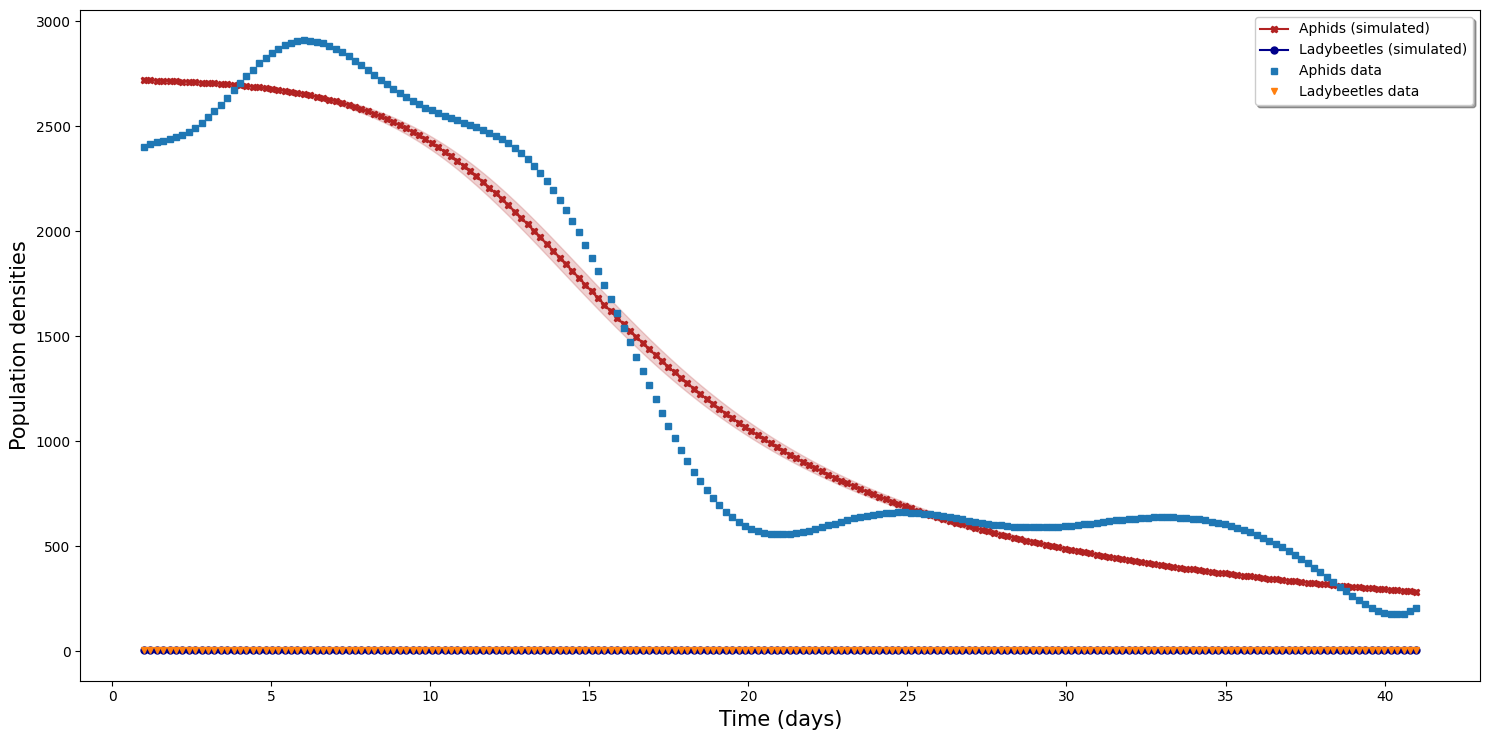

In [44]:
plt.figure(figsize=(15, 7.5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "firebrick",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=5,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="firebrick", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "darkblue",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=5,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="darkblue", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_density, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=5
)
plt.plot(
    time_observations, 
    ladybeetle_density, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=5
)

plt.legend(shadow=True)
plt.xlabel('Time (days)', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.show()

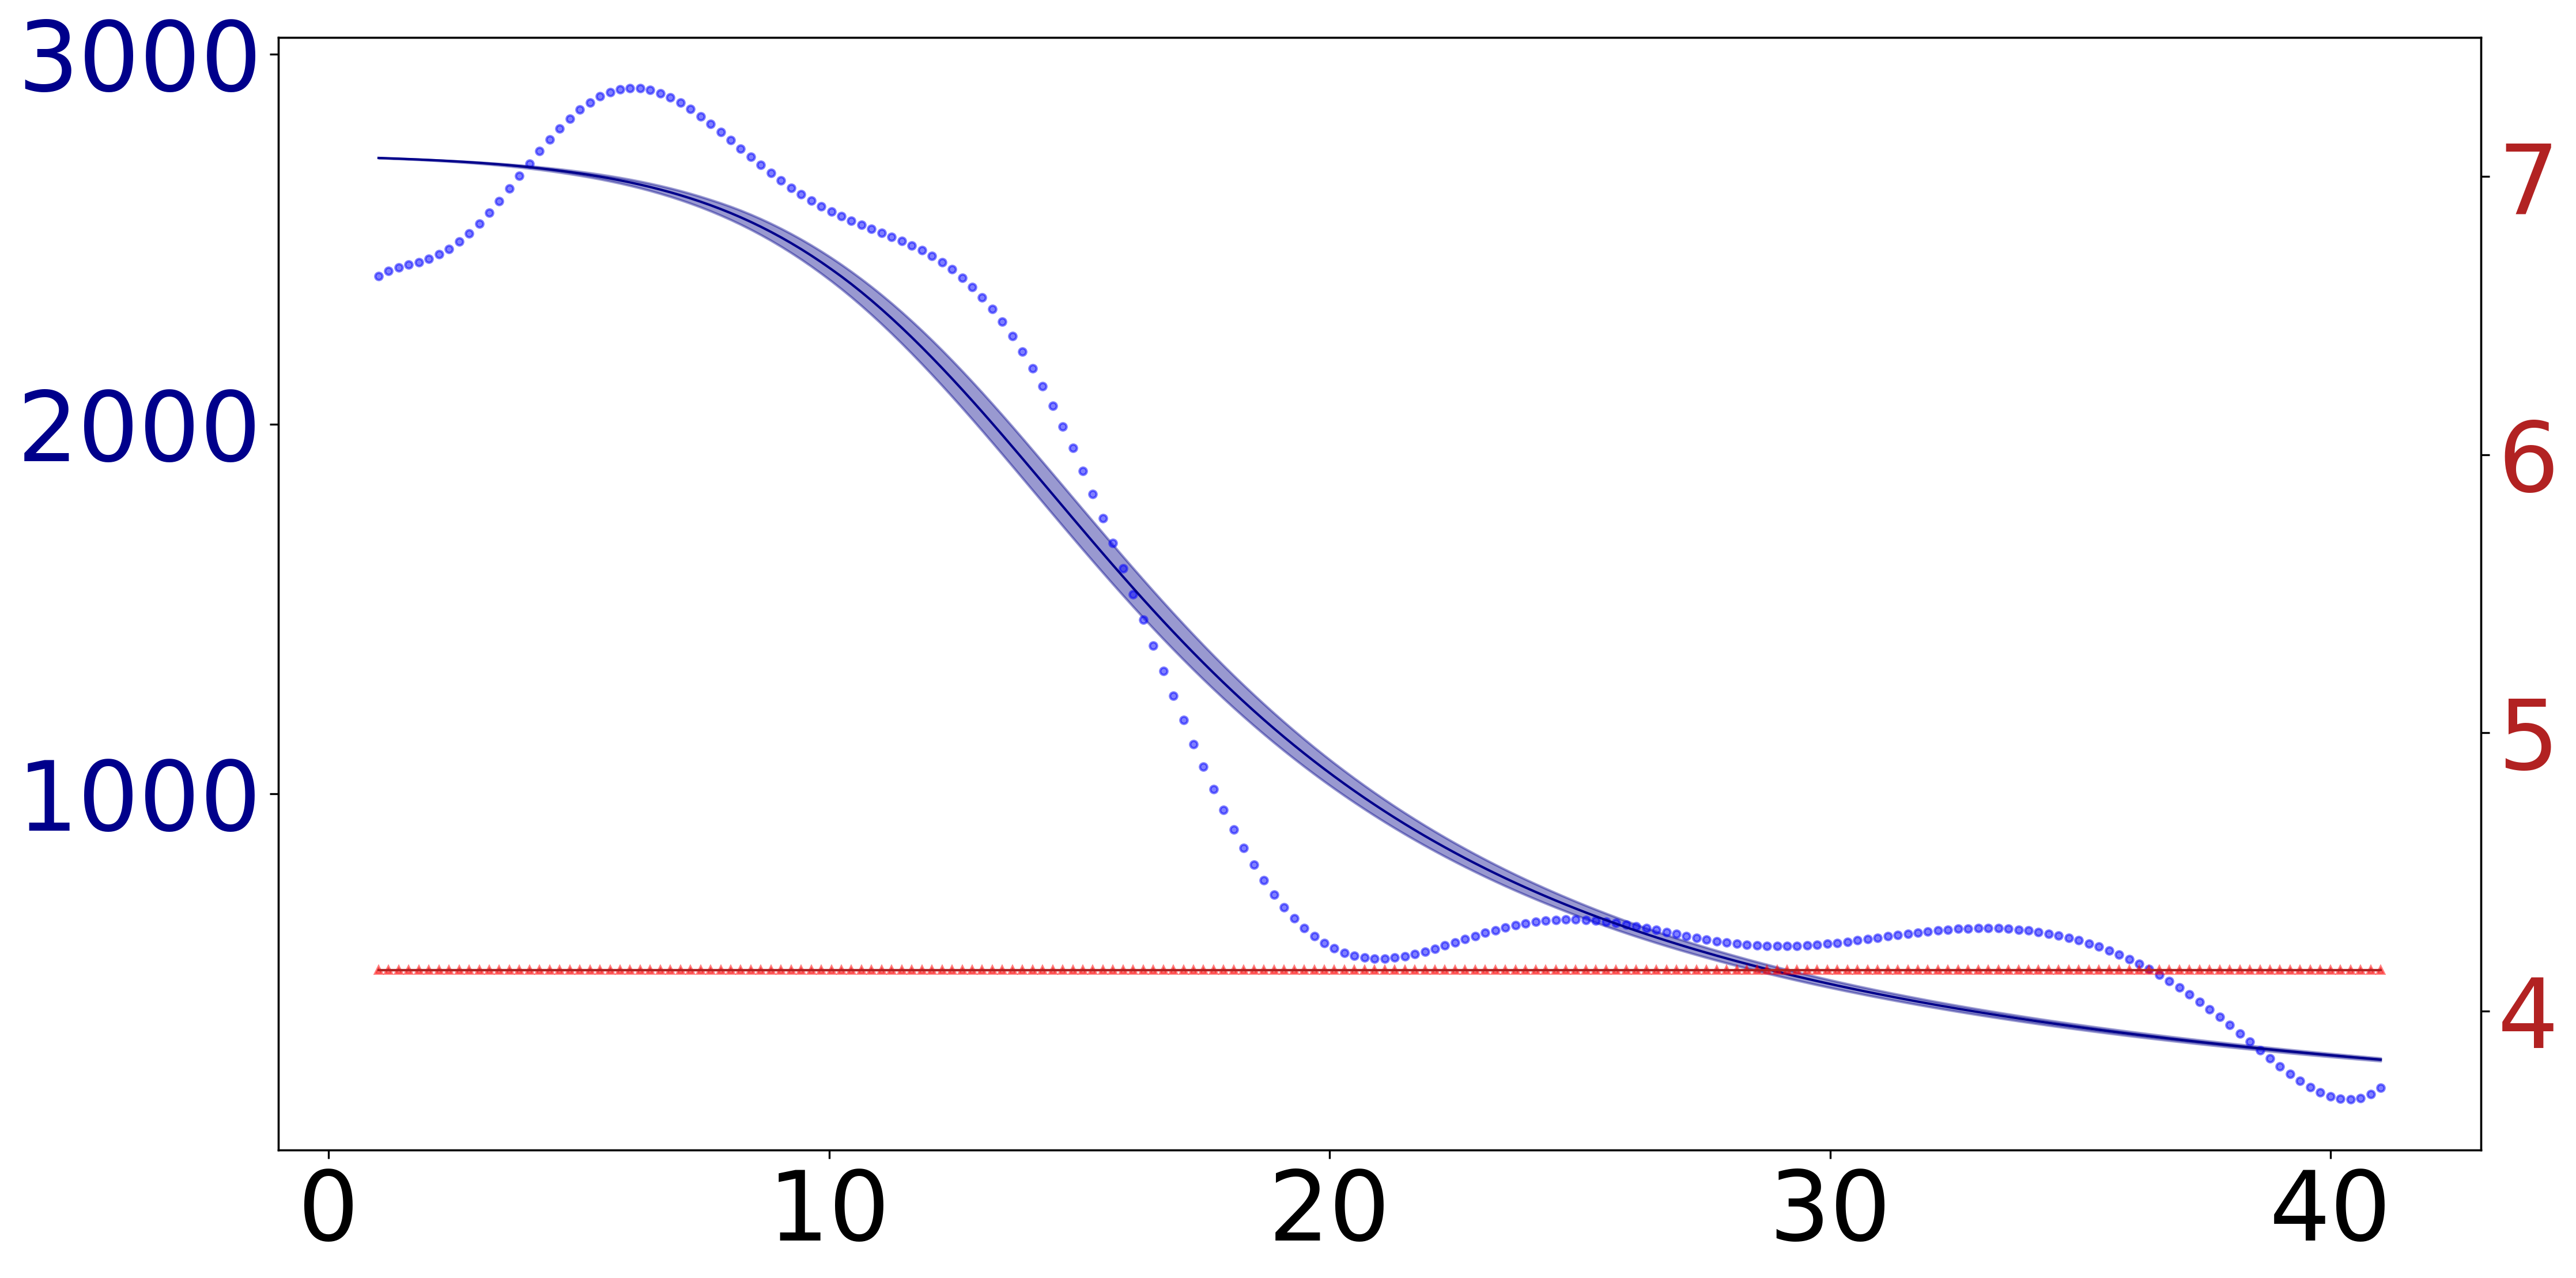

In [45]:
fig, ax1 = plt.subplots(1, 1, figsize = (15, 7.5), dpi = 300)
ax2 = ax1.twinx()
ax1.plot(time_observations, aphid_density, "bo", alpha = 0.5, markersize = 3)
ax2.plot(time_observations, ladybeetle_density, "r^", alpha = 0.5, markersize = 3)
ax1.plot(time_observations, y_fit[:, 0], "darkblue", alpha = 1.0, linewidth = 1)
ax2.plot(time_observations, y_fit[:, 1], "firebrick", alpha = 1.0, linewidth = 1)

ax1.fill_between(time_observations, y_min[:,0], y_max[:,0], color = "darkblue", alpha = 0.4)
ax2.fill_between(time_observations, y_min[:,1], y_max[:,1], color = "firebrick", alpha = 0.4)
#ax1.set_xlabel(r"Time (days)", fontsize=40)
#ax1.set_ylabel(r"Aphid", color = "darkblue", fontsize=40)
##ax2.set_ylabel(r"Ladybeetle", color = "firebrick", fontsize=40)
ax1.tick_params(axis = "y", labelcolor = "darkblue")
ax2.tick_params(axis = "y", labelcolor = "firebrick")
ax1.ticklabel_format(useOffset=False)
ax2.ticklabel_format(useOffset=False)

ax2.set_ylim([3.5, 7.5]) #ax2.set_ylim([4.1470, 4.1471])

ax1.tick_params(labelsize=40)
ax2.tick_params(labelsize=40)

plt.tight_layout()
plt.savefig("img/calibration_M04.png", dpi=300)
plt.show()

In [46]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # save the realizations in a Python dictionary
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_M04.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_M04.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

-- Exporting calibrated parameter to CSV


Gathering a21 realizations: 100%|███████████████| 2/2 [00:00<00:00, 1046.74it/s]

-- Exported done in 0.125 seconds


In [47]:
df_realizations

,r3,a21
0,5.225469e-08,0.000032
1,5.227914e-08,0.000032
2,5.226915e-08,0.000032
3,5.225401e-08,0.000032
4,5.225401e-08,0.000032
...,...,...
35995,5.221864e-08,0.000032
35996,5.222710e-08,0.000032
35997,5.227909e-08,0.000032
35998,5.230730e-08,0.000032
